# Вспомогательный код

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
import torch.nn as nn

class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

# Режимы обучения

Нам не обязательно поддерживать один и тот же `learning rate` в течение всего обучения. Более того, для того же SGD есть гарантии, что если правильно подобрать схему уменьшения `learning rate`, то он сойдется к глобальному оптимуму.

Мы можем менять `learning rate` по некоторым правилам.

## Ранняя остановка

Иногда мы можем сталкиваться с переобучением сети — появлением момента, когда качество на валидационной выборке начинает падать. Для того, чтобы бороться с этим, можно использовать раннюю остановку — прекращение обучения модели, когда ошибка на валидации начала расти.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/early_stopping.png" width="500"></center>

В Lightning для ранней остановки реализован callback `EarlyStopping` [🛠️[doc]](https://lightning-ai.webpkgcache.com/doc/-/s/lightning.ai/docs/pytorch/stable//common/early_stopping.html):

```python
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


class LitModel(LightningModule):
    def validation_step(self, batch, batch_idx):
        loss = ...
        self.log("val_loss", loss)


model = LitModel()
trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model)
```



 Также хорошая практика — сохранение лучшей модели:

 ```python
 # from L.pytorch.callbacks import ModelCheckpoint  # - doesn't work
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)
```

## Уменьшение скорости обучения на плато

Еще одним методом улучшения качества обучения является уменьшение скорости обучения на плато: когда значение функции потерь на валидационной выборке не улучшается какое-то количество эпох (`patience`), умножаем `learning rate` на некоторое значение `factor` < 1).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/resnet_18_and_34_layers.png"  width="700"></center>
<center><em>График изменения ошибки при обучении двух модификаций ResNet с 34 и 18 слоями соответственно</em></center>

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=5
)
```

Применим к нашей модели (выполнение занимает ~ 5 минут).

Реализуем ниже код для обучения модели на чистом PyTorch, чтобы разобраться с тем, как именно планировщик обучения встроен в алгоритм обучения.
Отказавшись временно от Lightning, мы должны будем явно перемещать объекты между CPU и GPU, а также следить за тем, что мы верно выбрали режим работы `model.train()` или `model.eval()`.

In [ ]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history


def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [ ]:
from tqdm.notebook import tqdm


def train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=None, num_epochs=5
):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, val_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        scheduler.step(val_loss)
    return train_history

In [ ]:
model = SimpleMNIST_NN_Batchnorm(n_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=1
)

model_name = "reduce_lr_on_plateu"

history = train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

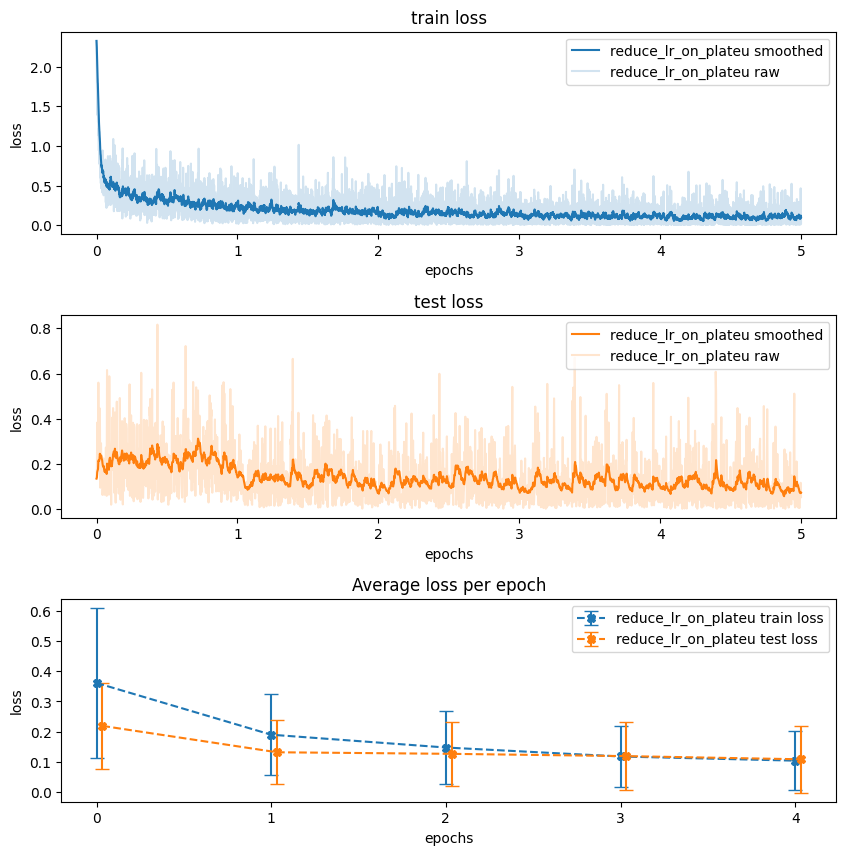

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

Для реализации работы планировщика обучения `ReduceLROnPlateau` в рамках PyTorch Lightning нам достаточно переопределить метод `configure_optimizers` и указать, за значением какой логируемой переменной необходимо "следить" во время обучения. Вся остальная логика будет выполнена Lightning автоматически.

In [ ]:
class PipelineWithScheduler(Pipeline):
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.1,
            mode="min",
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "loss_on_test",
        }
        return [optimizer], [lr_scheduler]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())
        return {"loss_on_test", loss}

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

model_name = "reduce_lr_on_plateu_lightning"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = PipelineWithScheduler(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={
        "lr": 1e-2,
    },
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


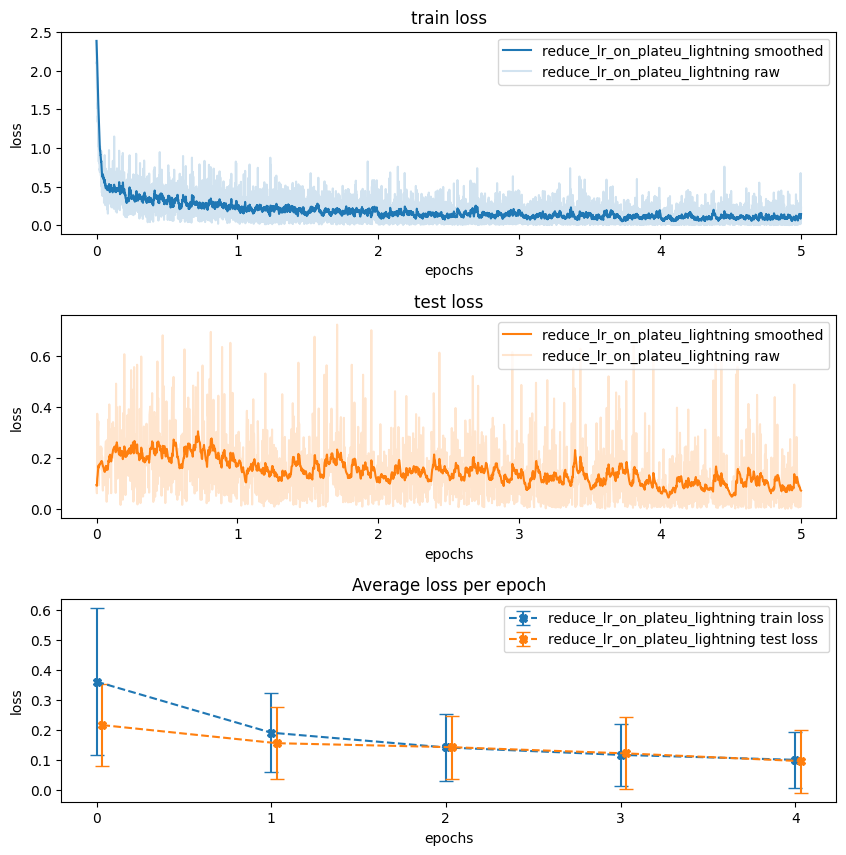

In [ ]:
history_plotter.plot([model_name])

## Понижение скорости обучения на каждой эпохе

Домножать `learning rate` на `gamma` каждую эпоху:

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

## Neural Network WarmUp

Для достаточно больших нейронных сетей практикуют следующую схему ([**gradual warmup** 🎓[arxiv]](https://arxiv.org/pdf/1706.02677.pdf)):

1. Поставить изначальный `learning rate` значительно ниже того, с которого мы обычно начинаем обучение.
2. За несколько эпох, например, 5, довести `learning rate` от этого значения до требуемого. Так мы не совершаем больших шагов, когда сеть еще ничего не знает о данных. За счет этого нейросеть лучше "адаптируется" к нашим данным.

Также такой `learning schedule` позволяет адаптивным оптимизаторам лучше оценить значения `learning rate` для разных параметров.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/neural_network_warmup.png" width="1000"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.02677.pdf">Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour</a></em></center>


$kn$ на изображении — это размер одного батча.

## Cyclical learning schedule


[[arxiv] 🎓 Cyclical Learning Rates for Training Neural Networks (Smith, 2017)](https://arxiv.org/pdf/1506.01186.pdf)

**Идея:**
Функция потерь может иметь сложный ландшафт. Нам бы хотелось:
* изучить побольше локальных минимумов,
* оценить качество в каждом локальном минимуме.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/Cyclic_LR_Schedule.png" width="750"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Для этого мы можем не все время понижать learning rate, а делать это **циклически**: то понижать, то повышать.

При **увеличении** learning rate модель может **выбраться** из одного локального минимума. При **уменьшении** — **сойтись** к следующему.


Есть две основные мотивации использования **циклического learning rate**:

* **Ускорение сходимости**: мы уже посмотрели на адаптивные оптимизаторы. Их недостатком является необходимость хранения в памяти квадратов градиентов. Для циклического learning rate это необязательно, его можно использовать с SGD, изменяя скорости в 3–4 раза. Аналогично с Adam — это позволит редким признакам быстрее обучаться (частые признаки будут немного “ломаться”, а затем восстанавливаться). Для таких целей важно подбирать learning rate вблизи оптимального. Идея этого представлена в [статье 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf).

* **Создание ансамблей моделей:** разные локальные минимумы будут давать ошибки на разных объектах. Можно сохранять модели в локальных минимумах и не только искать лучшую, но и устраивать между моделями голосования. Для этого learning rate изменяют в сотни раз. Идея этого представлена в [статье 🎓[article]](https://openreview.net/pdf?id=BJYwwY9ll). Обычно для создания ансамблей используют [циклический отжиг 🎓[arxiv]](https://arxiv.org/pdf/1608.03983.pdf).


 ### Ускорение сходимости

Добавление “дрожания” в learning rate [придумано 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf) как альтернатива Adam, позволяющая не хранить значения Momentum и сумм квадратов градиентов при дефиците вычислительных мощностей. По сходимости этот метод почти всегда уступает Adam и AdamW, поэтому редко используется.

Реализация данной идеи:

[[colab] 🥨 Циклическое изменение learning rate для ускорения сходимости](https://colab.research.google.com/drive/1DYfhoazJ9AGT0IFcBIybpM7wn3DEIoFm)

### Создание ансамблей моделей

Для создания ансамблей моделей learning rate циклически изменяют в сотни раз (а можно и до 0, как ниже), поэтому подбор оптимального значения learning rate не критичен. В качестве правила изменения используют циклический отжиг (cosine annealing cycles):

$$\text{lr}(t) = \frac {\text{lr}_0}{2}(\cos(\frac{\pi\cdot \mod(t-1, [T/M])}{[T/M]})+1),$$

где $\text{lr}_0$ — начальная скорость обучения, $T$ — общее количество итераций, $M$ — общее количество моделей, $t$ — текущая итерация.

В формулу можно добавить минимальное значение, но мы это делать не будем, т.к. это не обязательный параметр.


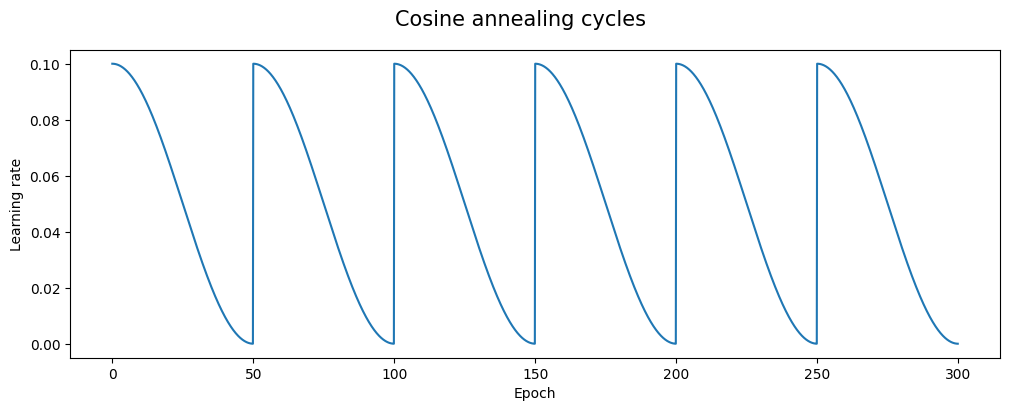

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# number of models (M in formula)
num_models = 6
# epoch per model
num_epochs = 50
# number of bats in dataset
len_dataset = 8

# total iteration number (T in formula)
total_iter = num_models * num_epochs * len_dataset

learning_rate_0 = 0.1

t = np.array(range(total_iter))
lr_t = (learning_rate_0 / 2) * (
    np.cos(np.pi * np.mod(t, total_iter / num_models) / (total_iter / num_models)) + 1
)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cosine annealing cycles", size=15)
ax.plot(t / len_dataset, lr_t)
ax.set(xlabel="Epoch", ylabel="Learning rate")
plt.show()

В PyTorch циклический отжиг реализован в модуле `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`.

Общее правило подбора скорости обучения $\text{lr}_0$: она должна быть достаточно большой, чтобы “ломать” обученную модель, при этом количество эпох для обучения каждой модели должно быть достаточным для получения приличного качества. В [статье 🎓[article]](https://openreview.net/pdf?id=BJYwwY9ll), например, используют 50 эпох, но это значение зависит от модели.

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=total_iter // num_models
)

Loss при обучении будет выглядеть примерно так (красная линия):

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/cosine_annealing_cycles.png" width="350"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Модели в конце цикла отжига сохраняются. Можно выбрать лучшую или построить ансамбль.


## Model soup

[[arxiv] 🎓 Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time (2022)](https://arxiv.org/pdf/2203.05482.pdf)

В статье была предложена интересная идея ансамблирования моделей, названная “суп моделей”. Она очень проста: **обучить несколько моделей** (для этого мы будем использовать **циклический отжиг**) и **агрегировать веса моделей**, которые соответствуют нескольким различным минимумам функции потерь, в одну модель.

Для “приготовления супа” возьмем датасет немного сложнее, чем MNIST, а именно CIFAR-10.

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar = datasets.CIFAR10("CIFAR10", train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(
    "CIFAR10", train=False, download=True, transform=transform
)

train_set, val_set = random_split(cifar, [40_000, 10_000])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 80318589.84it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


Соберем простую модель:

In [ ]:
import torch.nn as nn


class SimpleNet_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):  # input [batch, 3, 32, 32]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.pool(self.conv3(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Для обучения будем использовать Lightning, для расчета метрик — TorchMetrics. Это сделает код более универсальным (его можно использовать для ваших моделей с минимумом модификаций).

Для чтения логов будем использовать tbparse.

In [ ]:
import matplotlib.pyplot as plt
from tbparse import SummaryReader
from IPython.display import clear_output


def visualization(log_dir):
    # visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("epoch")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0]
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        ax = axs[ax_dict[metric]]
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")
    plt.show()

Есть [несколько подходов 🎓[arxiv]](https://arxiv.org/pdf/2203.05482.pdf) к “приготовлению супа”. Мы рассмотрим два.

**Uniform soup** (равномерный суп) — веса всех моделей суммируются с одинаковым весом:
$$\text{Model} = f(x, \frac{1}{k}\sum_{i=1}^{k}ϴ_i)$$

**Greedy soup** (жадный суп):
1. Модели сортируются по убыванию качества на валидационной (не на тестовой!!!) выборке.
2. Лучшая модель становится первым “ингредиентом” супа. Текущее качество “супа” определяется по значению метрики лучшей модели на валидационной (не на тестовой!!!) выборке.
3. Остальные отсортированные модели по очереди добавляются в суп. Качество новой модели определяется по значению метрики на валидационной (не на тестовой!!!) выборке. Если значение метрики новой модели лучше текущего качества супа, то модель добавляется в “суп”, а текущая метрика обновляется.

Качество “супа” определяется по тестовой выборке.

Код для методов реализован ниже. Для обучения отдельных моделей используется циклический отжиг.

In [ ]:
!mkdir ./soup_models_weights

In [ ]:
import lightning as L
from pathlib import Path
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)


class MakeSoup(L.LightningModule):
    def __init__(
        self,
        model,
        num_class,
        n_cycle_iter,
        cycle_epochs,
        show=True,
        soup_path="./soup_models_weights",
    ):
        super().__init__()
        self.cycle_epochs = cycle_epochs
        self.num_class = num_class
        self.n_cycle_iter = n_cycle_iter
        self.model = model
        self.show = show

        self.criterion = torch.nn.CrossEntropyLoss()

        # set metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=num_class,
                ),
                # MulticlassF1Score(num_classes=num_class,),
                # MulticlassAUROC(num_classes=num_class,)
            ]
        )

        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.models_data = []
        self.soup_path = Path(soup_path)

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=0.01,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=self.n_cycle_iter,
            eta_min=0,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # or 'epoch'
                "frequency": 1,
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        self.log("loss/train", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log("loss/val", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.val_metrics.update(y_hat, y)

    def on_validation_epoch_end(self):
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        if self.trainer.ckpt_path is not None:
            self.models_data.append(
                {
                    "path": self.trainer.ckpt_path,
                    "metrics": {
                        key: val.cpu().item() for key, val in val_metrics.items()
                    },
                }
            )

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        if self.show and self.current_epoch != 0:
            visualization(self.logger.log_dir)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        self.metrics.update(y_hat, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        predict = y_hat.argmax(dim=1).detach().cpu()
        true = y.detach().cpu()

        return {
            "predict_label": predict,
            "true_label": true,
        }

    def uniform_soup(self, skip_first=False):
        self.models_data.sort(key=lambda x: x["path"], reverse=True)
        if skip_first:
            models_data = self.models_data[1:].copy()
        else:
            models_data = self.models_data.copy()
        n_model = len(models_data)
        for i, item in enumerate(models_data):
            checkpoint = torch.load(
                item["path"], weights_only=True, map_location=self.device
            )["state_dict"]
            state_dict = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }
            if i == 0:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) for key, val in state_dict.items()
                }
            else:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) + uniform_soup_params[key]
                    for key, val in state_dict.items()
                }
            print(f'Adding {item["path"]} to soup.')
        self.model.load_state_dict(uniform_soup_params)
        path = self.soup_path / "model_uniform_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

    def greedy_soup(self, val_loader, metric="MulticlassAccuracy"):
        # sort
        self.models_data.sort(key=lambda x: x["metrics"][metric + "/val"], reverse=True)

        best_model_path = self.models_data[0]["path"]
        best_score = self.models_data[0]["metrics"][metric + "/val"]

        greedy_soup_ingredients = [best_model_path]

        checkpoint = torch.load(
            best_model_path, weights_only=True, map_location=self.device
        )["state_dict"]

        greedy_soup_params = {
            key.removeprefix("model."): val for key, val in checkpoint.items()
        }

        for i in range(1, len(self.models_data)):
            n = len(greedy_soup_ingredients)
            path = self.models_data[i]["path"]

            checkpoint = torch.load(path, weights_only=True, map_location=self.device)[
                "state_dict"
            ]

            ingredient_params = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }

            # mix ingredient
            potential_greedy_soup_params = {
                k: greedy_soup_params[k].clone() * (n / (n + 1.0))
                + ingredient_params[k].clone() * (1.0 / (n + 1.0))
                for k in ingredient_params
            }

            self.val_metrics.reset()
            self.model.load_state_dict(potential_greedy_soup_params)
            # validate
            with torch.inference_mode():
                for batch_idx, batch in enumerate(val_loader):
                    self.test_step(batch, batch_idx)
                score = self.metrics.compute()[metric]
                self.metrics.reset()

            if score > best_score:
                greedy_soup_ingredients.append(path)
                best_score = score
                greedy_soup_params = potential_greedy_soup_params
                print(
                    f"Adding to soup. New soup is {greedy_soup_ingredients}. ",
                    f"With score = {best_score}",
                )

        self.model.load_state_dict(greedy_soup_params)
        path = self.soup_path / "model_greedy_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

Параметры обучения представлены ниже. Запуск обучения закомментирован. Обучение модели занимает примерно 30 минут на GPU.

In [ ]:
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

L.seed_everything(42)

n_model = 5
cycle_epochs = 20
num_class = 10

model = SimpleNet_CIFAR()

n_cycle_iter = cycle_epochs * len(train_loader)

pl_model = MakeSoup(model, num_class, n_cycle_iter, cycle_epochs)

lr_monitor = LearningRateMonitor(logging_interval="step")
save_checkpoint = ModelCheckpoint(
    every_n_epochs=cycle_epochs,
    save_top_k=n_model,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

trainer = L.Trainer(
    max_epochs=cycle_epochs * n_model,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log/"),
    callbacks=[lr_monitor, save_checkpoint],
)

# trainer.fit(pl_model, train_loader, val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Для ускорения работы мы загрузим заранее обученные модели и логи обучения:

In [ ]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.2/L07/weights/model_soup_log.zip
!unzip -qq model_soup_log.zip

Загрузим модели, посчитаем статистику по предсказаниям и точность на выборке для валидации и загрузим последнее в нужное поле модели. Посмотрим на логи обучения.

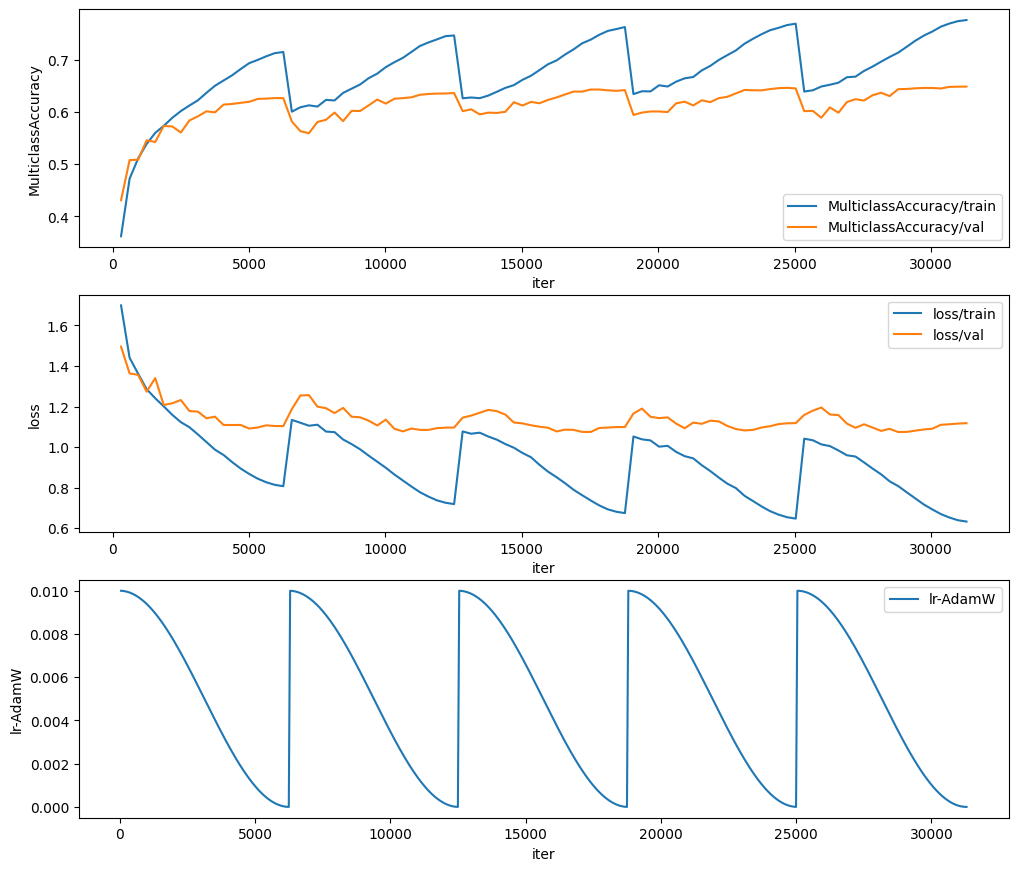

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.635899007320404     │
│         loss/val          │    1.0963464975357056     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6415534615516663     │
│         loss/val          │    1.0986661911010742     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.644766092300415     │
│         loss/val          │    1.1180671453475952     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6482957005500793     │
│         loss/val          │    1.1176204681396484     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6261476278305054     │
│         loss/val          │    1.1035901308059692     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
import os
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

visualization("/content/model_soup_log/log/lightning_logs/version_0")
weights_path = Path("/content/model_soup_log/log/lightning_logs/version_0/checkpoints/")
file_list = os.listdir(weights_path)
file_list.sort()

for f in file_list:
    path = weights_path / f

    trainer.validate(
        model=pl_model,
        dataloaders=val_loader,
        ckpt_path=path,
    )

Мы сохранили пути до моделей и их точность:

In [ ]:
pl_model.models_data

[{'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.635899007320404}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6415534615516663}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.644766092300415}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6482957005500793}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6261476278305054}}]

Посчитаем точность моделей на тестовой выборке:

In [ ]:
for f in file_list:
    path = weights_path / f

    trainer.test(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6317999958992004     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6402999758720398     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6462000012397766     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6441000699996948     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6267000436782837     │
└───────────────────────────┴───────────────────────────┘

Лучшая модель имеет точность $64.62\%$.

Посчитаем точность на тестовой выборке в случае голосования моделей (выбирается класс, за который проголосовало большинство).

In [ ]:
import numpy as np


ans_statistic = np.zeros((n_model, len(cifar_test)))
true_label = np.zeros((len(cifar_test)))

for i, f in enumerate(file_list):
    path = weights_path / f

    prediction = trainer.predict(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )
    batch_size = prediction[0]["predict_label"].shape[0]
    for batsh_idx, items in enumerate(prediction):
        ans_statistic[i, batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "predict_label"
        ].numpy()
        true_label[batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "true_label"
        ].numpy()

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Визуализируем предсказания наших $5$ моделей для первых $100$ объектов выборки для тестирования. Убедимся, что модели дают разные ответы, а значит их можно использовать для ансамбля.

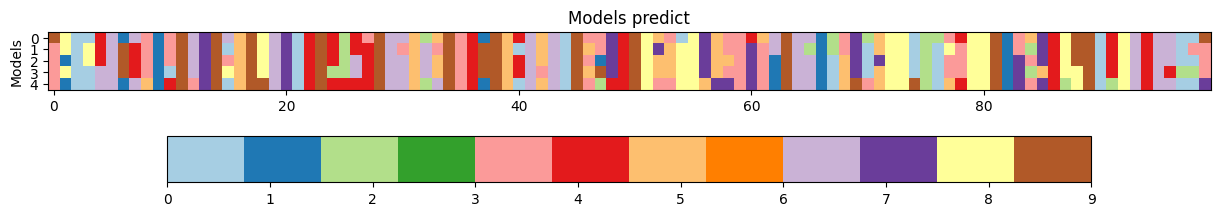

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(ans_statistic[:, :100], cmap="Paired")
plt.colorbar(orientation="horizontal")
plt.title("Models predict")
plt.ylabel("Models")
plt.yticks(range(5))
plt.show()

In [ ]:
predict_label = np.zeros((len(cifar_test)))
for i in range(len(cifar_test)):
    values, counts = np.unique(ans_statistic[:, i], return_counts=True)
    predict_label[i] = values[counts.argmax()]
predict_label

array([3., 8., 0., ..., 5., 0., 7.])

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Ensemble accuracy {accuracy_score(true_label, predict_label)}")

Ensemble accuracy 0.6567


Голосование моделей дает точность $65.67\%$. На $1.05\%$ лучше лучшей модели, но при этом на $1$ предсказание уходит в $5$ раз больше вычислительных ресурсов.

Попробуем применить `uniform_soup`:

In [ ]:
model = pl_model.uniform_soup()
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6455999612808228     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6455999612808228}]

Точность хуже. Посмотрим на наши модели: первая модель имеет точность ниже, чем остальные. Это связано с тем, что она стартовала с худшей позиции.

Уберем эту модель из супа:

In [ ]:
model = pl_model.uniform_soup(skip_first=True)
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6483999490737915     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6483999490737915}]

Получили точность $64.84\%$. На $0.22\%$ лучше, чем у лучшей модели и на $0.83\%$ меньше, чем у голосования. При этом модель прогоняется только $1$ раз.

Попробуем `greedy_soup`:

In [ ]:
model = pl_model.greedy_soup(val_loader)
trainer.test(pl_model, test_loader)

Adding to soup. New soup is [PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'), PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt')].  With score = 0.6521247029304504


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6484999656677246     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6484999656677246}]

Получили точность $64.85\%$. Это на $0.23\%$ лучше лучшей модели и на $0.82\%$ хуже голосования. При этом модель прогоняется только $1$ раз.

Таким образом, суп моделей является альтернативой ансамблированию методом голосования, позволяющей поднять точность предсказания без увеличения необходимых для Inference вычислительных ресурсов.

## Взаимодействие learning schedule и адаптивного изменения learning rate

И то, и другое меняет `learning rate`:

* `learning scheduler` — глобально,

* адаптивные оптимизаторы — для каждого веса отдельно.

Часто их применяют вместе, особенно в случае критерия ранней остановки и WarmUp.

Однако в случае циклического режима обучения так делают не всегда. Дело в том, что одна из его задач — как раз избежать использования адаптивных оптимизаторов, требующих больше памяти и дополнительных вычислений.

При этом никаких препятствий к использованию того же Adam в компании вместе с циклическим режимом обучения нет. Так делают, например, в [статье 🎓[arxiv]](https://arxiv.org/pdf/2004.02401.pdf).

Кроме того, есть сложные оптимизаторы, составленные из нескольких простых оптимизаторов и шедулеров. Например, есть проект [Ranger21 🐾[git]](https://github.com/lessw2020/Ranger21), не получивший оформления в виде библиотеки на [PyPi 🛠️[doc]](https://pypi.org/), авторы которого пытаются “померить” разные идеи из статей.

[[arxiv] 🎓 Ranger21: A Synergistic Deep Learning Optimizer (Wright, Demeure, 2021)](https://arxiv.org/pdf/2106.13731.pdf)

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/ranger21.png" width="700"></center>

<center><em>Loss и accuracy при использовании Adam и Ranger21 при обучении ResNet50 на наборе данных ImageNet</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2106.13731.pdf">Ranger21: A Synergistic Deep Learning Optimizer</a></em></center>

Результаты выглядят неплохо. Недостатком этого оптимизатора является большое количество хранимых параметров и гиперпараметров, а также тестирование на ограниченном числе моделей.